# Instrucciones:

El notebook se puede ejecutar linealmente, sin embargo el procesamiento en la parte de descarga de imagenes y extracción de caracteristicas es algo pesado, se hace esta primera iteración con subset de 2000 registros.

Tambien dejamos un dos archivos en la ruta

1.   train.csv - El dataset que se debe descargar en el primer bloque de código esto se hace por medio del id del archivo en drive.
2.   images_descriptors.csv - El segundo archivo se puede cargar desde la sección de modelo, este archivo ya contiene las caracteristicas extraidas, para probar en un modelo.





Importe de librerías

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import numpy as np
import pandas as pd 

import cv2 as cv2 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import os

import scipy
import scipy.spatial
import _pickle as pickle

Se instala esta versión especifico de opencv para la extracción de caracteristcas ya que con otras versiones presentabamos problemas

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 74kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Lectura de archivo

Descarga del archivo con el dataset original de la competencia (https://www.kaggle.com/c/landmark-retrieval-challenge/data


In [ ]:
!gdown --id 1QtE_1jc_vtePpFR5VxQ5dgkofHeg2RiE

Downloading...
From: https://drive.google.com/uc?id=1QtE_1jc_vtePpFR5VxQ5dgkofHeg2RiE
To: /content/train.csv
131MB [00:01, 68.2MB/s]


El dataset cuenta con las URLs de las imagenes y una marca del lugar 'Landmark_id'

In [ ]:
df = pd.read_csv('train.csv')
df

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018
...,...,...,...
1225024,4bb5a501e5b26a6a,https://lh6.googleusercontent.com/-mRrQU3t5cYw...,9737
1225025,2cd8a404796cfe0e,https://lh6.googleusercontent.com/-0UB5gFx6w7M...,7758
1225026,8733b8b469fb8c1b,http://lh3.ggpht.com/-TDQWNVvJQDI/SI3HZSA4D3I/...,13170
1225027,14dd9e8790397c83,https://lh4.googleusercontent.com/-anV4Xpo0UuM...,5669


# Análisis exploratorio y limpieza

In [ ]:
df['landmark_id'].value_counts()

9633     49451
6051     49222
None     34330
6599     22762
9779     18062
         ...  
4329         1
12502        1
3178         1
13163        1
5082         1
Name: landmark_id, Length: 14947, dtype: int64

In [ ]:
df.shape

(1225029, 3)

In [ ]:
df.describe()

,id,url,landmark_id
count,1225029,1225029,1225029
unique,1225029,1190700,14947
top,965ac2bb75a283ad,None,9633
freq,1,34330,49451


Eliminamos los registros nulos que en realidad no nos aportan a el análisis


In [ ]:
df = df.replace(to_replace='None', value=np.nan).dropna()
df.shape

(1190699, 3)

Obtenemos los 10 lugares con mas imagenes

In [ ]:
top10 = df['landmark_id'].value_counts().head(10)
top10

9633    49451
6051    49222
6599    22762
9779    18062
2061    12999
5554    10802
6651     9296
5376     9048
6696     9031
2743     8821
Name: landmark_id, dtype: int64

In [ ]:
top10_array = list(top10.index)
top10_array

['9633',
 '6051',
 '6599',
 '9779',
 '2061',
 '5554',
 '6651',
 '5376',
 '6696',
 '2743']

Obtenemos una submuestra de 200 imagenes por lugar para esta primera iteración ya que el procesamiento de las imagenes es pesada, en futuras iteraciones miraremos como optimizar nuestros algoritmos

In [ ]:
top10_dict = {}
i=0
for id in top10_array:
  top10_dict[i] = df[df['landmark_id'] == id].head(200)
  print(top10_dict[i].shape)
  i=i+1

(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)
(200, 3)


In [ ]:
top10_dict[0]

,id,url,landmark_id
64,e86c3c992591d147,https://lh5.googleusercontent.com/-7AoJnw2esWw...,9633
70,ecd857884464154d,https://lh6.googleusercontent.com/-xAmqD_PLM28...,9633
88,6c1b01259ae87ddc,https://lh6.googleusercontent.com/-QCDV0ENYxPI...,9633
132,f92fa6b19b56aa0a,https://lh3.googleusercontent.com/-oYFvHLf8HEQ...,9633
138,9c5f1cea9834d581,https://lh5.googleusercontent.com/-Q15GMLfJpdc...,9633
...,...,...,...
5471,f2beaa2b6ccfe8cb,https://lh4.googleusercontent.com/-1UvEY83HYeM...,9633
5477,202ade0a58f63db5,https://lh3.googleusercontent.com/-UBgeRLXyUVQ...,9633
5535,921d6fbf521a809f,http://lh6.ggpht.com/-Eo_dIomKLjw/TUDLESrwdTI/...,9633
5545,07c52e0446e0457a,https://lh5.googleusercontent.com/-N00YjOXZC5E...,9633


In [ ]:
df_test = pd.DataFrame()
for value in top10_dict.values():
  df_test = df_test.append(value, ignore_index=True)
df_test.shape

(2000, 3)

# Descarga de imagenes

En el siguiente bloque de código se descargan las imagenes y se hace un control de errores, ya que en muchos casos las URLs estan caducadas o las imagenes contienen problemas

In [ ]:
from urllib import error

X = []
Y = []
errors = 0
for row in df_test[['url','landmark_id']].values:
  
  try:
    img = io.imread(row[0]) 
    if img is None:
      errors += 1
      continue
    X.append(img)
    Y.append(row[1])
 
  except (IOError, SyntaxError) as e:
    errors += 1
  except ValueError as e:
    errors += 1

print(f'cantidad de imagenes no encontradas: {errors}')

X = np.array(X)
Y = np.array(Y)



cantidad de imagenes no encontradas: 138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Ejemplo de una imagen, analizando varias imagenes hay imagenes giradas y otras donde la persona es el foco principal y no el lugar

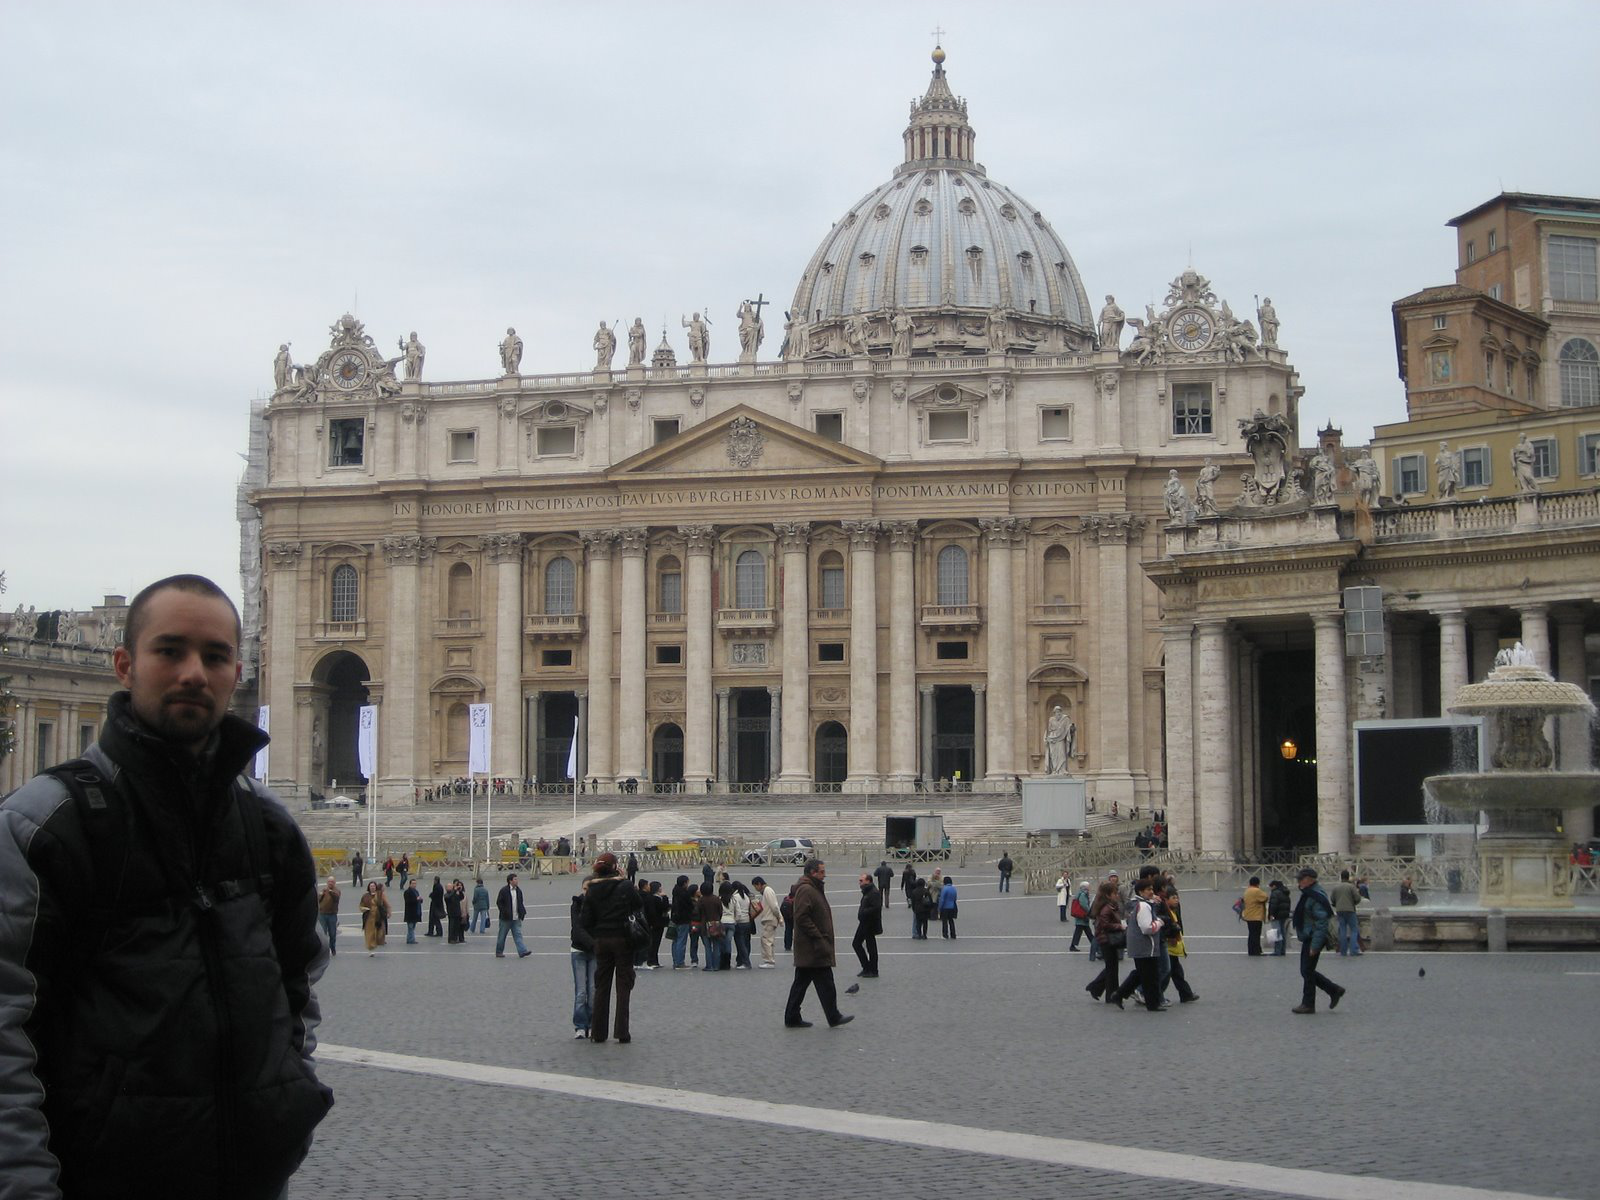

In [ ]:
for url in df_test.iloc[5:6]['url']:
  image = io.imread(url) 
  image_2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  cv2_imshow(image_2)
  print('\n')

# Extracción de caracteristicas

Se usa Kaze como metodo de extracción de caracteristicas de imagenes de la libreria opencv, se puede utilizar otros de la misma libreria como ORB o SIFT

In [ ]:
def extract_features(image, vector_size=32):
    try:
        alg = cv2.KAZE_create()
        kps = alg.detect(image) # Se obtienen los keypoints de las imagenes

        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()

        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])

    except cv2.error as e:
        print ('Error: ', e)
        return None
        
    return dsc

def batch_extractor(X, Y, pickled_db_path="features.pck"):
    result = {}
    i = 0
    for img in X:
        result[str(i)] = np.append(extract_features(img) , int(Y[i]))
        i = i+1    

    # Se guardan las caracteristicas en un archivo pickle
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)


1. Se ejecuta la función batch_extractor pasandole todas las imagenes, el cual se encargara de llamar la función extract_features para obtener todas las caracteristicas y dejarlas su landmark_id correspondiente.
2. Se extrae la información de las caracteristicas del archivo pickle que genera la función anterior





In [ ]:
batch_extractor(X,Y)

scores = {} 
if os.path.getsize('features.pck') > 0:      
    with open('features.pck', "rb") as f:
        unpickler = pickle.Unpickler(f)
        scores = unpickler.load()
        

In [ ]:
test_model = pd.DataFrame(scores.values())

Miramos como quedan las caracteristicas representadas en un dataframe, en la ultima columna esta el valor a predecir

In [ ]:
test_model

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,-0.000664,-0.001693,0.003246,0.009216,-0.011522,-0.005201,0.014313,0.023654,-0.009667,0.002223,0.011904,0.014028,0.001169,0.003259,0.010120,0.004168,0.000462,-0.001462,0.005985,0.008476,-0.000197,0.017676,0.033945,0.056687,-0.085085,0.027069,0.112490,0.095892,-0.442268,-0.001495,0.457106,0.149455,-0.002888,0.002781,0.006871,0.006042,0.014313,-0.001718,0.042445,0.061442,...,-0.229469,0.240577,0.444741,0.018099,0.029750,0.093173,0.166811,0.033431,-0.030686,0.046411,0.034994,-0.020570,0.053810,0.152521,0.223502,-0.071520,-0.103436,0.171824,0.320287,0.025903,-0.106371,0.111099,0.131975,0.028137,-0.034348,0.056114,0.042269,0.019099,-0.022249,0.083975,0.073933,-7.639314e-02,0.110793,0.199087,0.231683,0.034195,0.063746,0.062195,0.099304,9633.0
1,0.047247,0.010677,0.127108,0.154313,-0.090806,-0.077606,0.174853,0.177696,-0.035320,-0.021626,0.103468,0.112415,-0.012413,-0.011496,0.040147,0.040236,-0.055280,-0.015743,0.272731,0.220441,-0.008195,-0.017235,0.238965,0.275357,-0.068924,0.020219,0.172392,0.190296,-0.003603,0.000392,0.028500,0.031676,-0.048274,0.003219,0.237526,0.204499,0.012232,0.061951,0.291554,0.299209,...,0.009247,0.453777,0.467122,-0.039931,-0.030198,0.156627,0.100160,-0.014840,-0.116443,0.031414,0.116443,-0.107750,-0.121433,0.127976,0.178750,-0.036299,-0.178965,0.237248,0.352111,-0.040190,-0.032855,0.077595,0.123133,-0.006847,-0.058660,0.022736,0.063328,0.009222,-0.014083,0.075825,0.063924,-1.314617e-02,-0.009072,0.049972,0.046715,-0.011000,-0.025803,0.063860,0.078336,9633.0
2,0.039447,0.001574,0.069156,0.060533,0.043634,0.029634,0.213416,0.243436,-0.045534,0.038765,0.146393,0.140823,-0.007055,0.003327,0.088385,0.082228,0.036553,0.042413,0.181104,0.136550,0.046423,-0.056378,0.312201,0.319786,-0.040215,-0.099095,0.245026,0.279666,-0.009588,-0.022024,0.148933,0.064074,0.047262,-0.007826,0.186694,0.059731,-0.035978,0.005169,0.138535,0.376303,...,-0.033319,0.177574,0.311653,0.019218,0.007845,0.115299,0.105573,-0.042318,0.033991,0.071820,0.099160,-0.037826,0.135048,0.104241,0.229210,-0.000636,0.252399,0.047614,0.347881,0.030274,0.042638,0.138232,0.079574,-0.015212,-0.053692,0.041780,0.086923,0.017204,-0.000693,0.073509,0.120011,-1.523582e-02,0.016579,0.036231,0.245408,0.002188,-0.009622,0.036995,0.079269,9633.0
3,-0.033495,-0.018430,0.102787,0.090641,-0.008182,0.054522,0.168051,0.125552,0.013729,0.003688,0.104014,0.090581,0.037606,0.026065,0.051141,0.058861,-0.034319,0.024559,0.096705,0.109573,0.079277,-0.068403,0.332228,0.309286,0.145559,0.024003,0.412131,0.251588,0.058599,0.032863,0.126385,0.097254,-0.003023,0.000745,0.078334,0.113859,0.022242,0.077031,0.190629,0.261367,...,-0.047297,0.079019,0.330179,-0.008692,-0.019948,0.087465,0.189534,-0.001599,-0.060721,0.068728,0.319838,0.026204,-0.035481,0.140883,0.332787,0.001797,0.027069,0.117368,0.250342,-0.015259,0.008542,0.085074,0.151683,0.040249,-0.053247,0.067867,0.121480,0.081319,0.013962,0.145041,0.176322,-1.050868e-02,0.009679,0.089197,0.145784,-0.007460,0.006521,0.055887,0.101328,9633.0
4,-0.058567,0.015712,0.085616,0.082889,-0.124639,0.096747,0.281662,0.197722,0.026513,0.039191,0.077575,0.075332,0.089953,0.005715,0.093605,0.076488,-0.008314,-0.000572,0.019222,0.036502,-0.157006,0.069078,0.313514,0.247599,-0.014313,0.092831,0.402757,0.354586,0.095072,0.020737,0.138146,0.106040,-0.002887,-0.005791,0.005396,0.008215,-0.069491,0.052374,0.102793,0.127426,...,-0.049598,0.153426,0.087648,-0.031247,-0.012457,0.036361,0.014761,0.032919,-0.028604,0.225837,0.241726,0.148119,-0.112238,0.271135,0.326516,-0.000050,-0.010005,0.153715,0.112625,-0.026658,0.043454,0.029929,0.054176,0.041886,-0.040147,0.128891,0.091721,-0.007924,-0.009154,0.066686,0.064858,-6.257047e-04,0.008948,

El siguiente bloque de codigo se crea para persistir los datos de las caracteristicas importantes de las imagenes ya que el procesamiento es bastante pesado.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

test_model.to_csv("img_features.csv")
uploaded = drive.CreateFile({'title': 'images_descriptors_300.csv'})
uploaded.SetContentFile("img_features.csv")
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1H7E0WIKv1PdD9--V4jclwOqK9gtpxDvD


# Modelo

Linea para descargar el archivo con las caracteristicas y cargarlo en un dataframe nuevamente (Esto se utiliza para no tener que volver a descargar y procesar todas las imagenes y poder probar otras cosas)

In [ ]:
# Linea para descargar archivo con caractericas importantes de las imagenes
# !gdown --id 1SUS13Eg9r9yZa66sBJk5mz49Pg4fBwQ2
# test_model = pd.read_csv('images_descriptors.csv')



*  Obtenemos nuestras caracteristicas X y Y a partir del dataframe
*  Probamos que este funcionando PCA



In [ ]:
from sklearn.decomposition import PCA

X = test_model.iloc[:,0:2048]
Y = test_model.iloc[:,-1]

pca = PCA(n_components=10)
Xp = pca.fit_transform(X)

In [ ]:
X.shape, Xp.shape

((1862, 2048), (1862, 10))

Se hace un split de datos 70% de entrenamiento y 30% de prueba

In [ ]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,Y,test_size=.3)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((1303, 2048), (559, 2048), (1303,), (559,))

Se utilia GaussianNB para la clasificación

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

dt = GaussianNB()
dt.fit(Xtr, ytr)
dt.score(Xtr, ytr), dt.score(Xts, yts)

(0.7551803530314658, 0.18962432915921287)

Se busca cual es la cantidad optima de componentes con PCA

In [ ]:
cs = range(10,200,5)
dtr, dts = [], []
for n_components in cs:
    print (".", end="")
    pca = PCA(n_components=n_components)
    pca.fit(Xtr)

    Xt_tr = pca.transform(Xtr)
    Xt_ts = pca.transform(Xts)

    dt.fit(Xt_tr,ytr)
    ypreds_tr = dt.predict(Xt_tr)
    ypreds_ts = dt.predict(Xt_ts)
    ypreds_tr.shape, ypreds_ts.shape
    dtr.append(np.mean(ytr==ypreds_tr))
    dts.append(np.mean(yts==ypreds_ts))

......................................

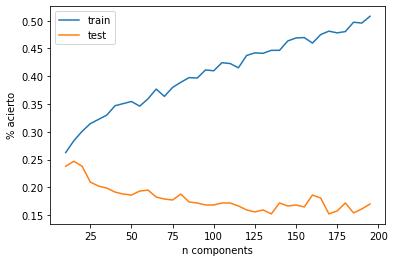

In [ ]:
plt.plot(cs, dtr, label="train")
plt.plot(cs, dts, label="test")
plt.xlabel("n components")
plt.ylabel("% acierto")
plt.legend()

Número optimo de componentes principales

In [ ]:
best_cs = cs[np.argmax(dts)]
best_cs

15

Se predice nuevamente con el numero de componentes sugerido

In [ ]:
pca = PCA(n_components=5)
pca.fit(Xtr)

Xt_tr = pca.transform(Xtr)
Xt_ts = pca.transform(Xts)
dt.fit(Xt_tr,ytr)
ypreds_tr = dt.predict(Xt_tr)
ypreds_ts = dt.predict(Xt_ts)
ypreds_tr.shape, ypreds_ts.shape
np.mean(ytr==ypreds_tr),np.mean(yts==ypreds_ts)

(0.26630851880276285, 0.24865831842576028)

Etiquetas de los lugares de las imagenes

In [ ]:
labels = list(set(Y))
for i in range(0, len(labels)):
    labels[i] = int(labels[i])

labels

[5376, 9633, 6051, 6599, 6696, 2061, 5554, 9779, 2743, 6651]

Se hace plot de la matrix de confusión usando esta función proporcionada por el usuario George Fisher en kaggle: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix



```
Copyright 2017 George Fisher

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```




In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Se dibuja la matrix de confusión normalizada y sin normalizar

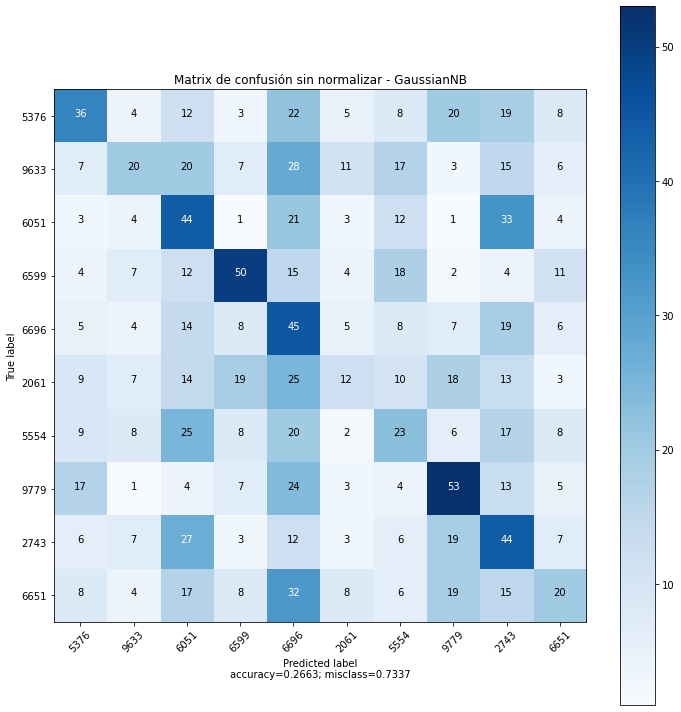

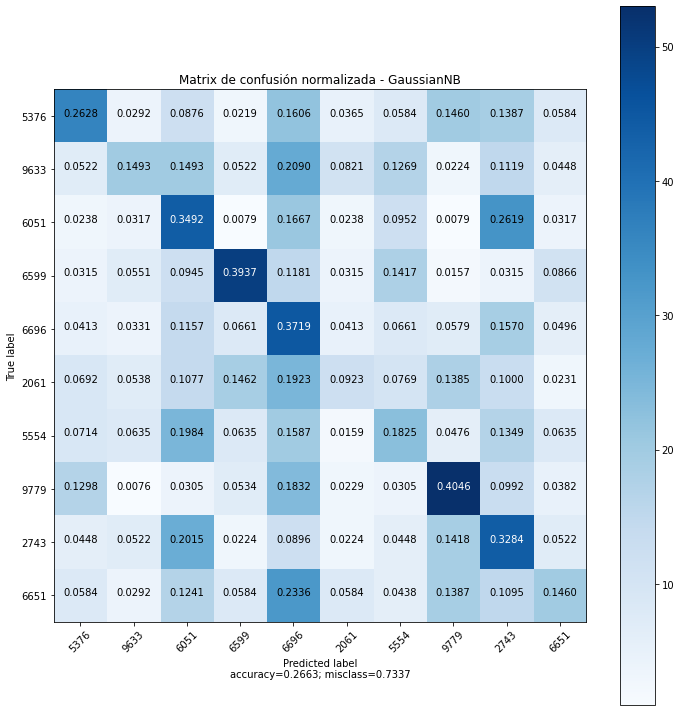

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(ytr, ypreds_tr) # Se construye la matrix de confusión con los y_verdaderos y y_predichos
matrix

plot_confusion_matrix(cm = matrix, normalize = False, target_names = labels, title  = "Matrix de confusión sin normalizar - GaussianNB")
plot_confusion_matrix(cm = matrix, normalize = True, target_names = labels, title  = "Matrix de confusión normalizada - GaussianNB")

Reporte de las predicciones con otras métricas

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ytr, ypreds_tr, labels = labels))

              precision    recall  f1-score   support

        5376       0.23      0.35      0.28       126
        9633       0.23      0.33      0.27       134
        6051       0.18      0.37      0.25       121
        6599       0.21      0.09      0.13       130
        6696       0.36      0.40      0.38       131
        2061       0.35      0.26      0.30       137
        5554       0.44      0.39      0.41       127
        9779       0.26      0.15      0.19       137
        2743       0.30      0.15      0.20       134
        6651       0.21      0.18      0.19       126

    accuracy                           0.27      1303
   macro avg       0.28      0.27      0.26      1303
weighted avg       0.28      0.27      0.26      1303

